<a href="https://colab.research.google.com/github/HackyRoot/SeeFood/blob/master/SeeFood_(Transfer_Learning).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# SeeFood

## Import packages

In [29]:
import tensorflow as tf
import tensorflow_hub as hub

tf.__version__

'2.2.0'

In [3]:
import os
import numpy as np
import matplotlib.pyplot as plt

In [35]:
from tensorflow.keras import Sequential
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Dense, InputLayer, Dropout
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.losses import CategoricalCrossentropy

## Load data

Source: https://www.kaggle.com/dansbecker/hot-dog-not-hot-dog

In [ ]:
!rm data.zip* && rm -r data/
!wget https://raw.githubusercontent.com/HackyRoot/SeeFood/master/data.zip
!unzip data.zip
!ls

In [6]:
PATH = os.path.join('/content/data')
train_dir = os.path.join(PATH, 'train')
val_dir = os.path.join(PATH, 'val')

In [7]:
train_hotdog_dir = os.path.join(train_dir, 'hot_dog')
train_not_hotdog_dir = os.path.join(train_dir, 'not_hot_dog')

val_hotdog_dir = os.path.join(val_dir, 'hot_dog')
val_not_hotdog_dir = os.path.join(val_dir, 'not_hot_dog')

## Understand the data

In [8]:
num_hotdog_train = len(os.listdir(train_hotdog_dir))
num_not_hotdog_train = len(os.listdir(train_not_hotdog_dir))

num_hotdog_val = len(os.listdir(val_hotdog_dir))
num_not_hotdog_val = len(os.listdir(val_not_hotdog_dir))

total_train = num_hotdog_train + num_not_hotdog_train
total_val = num_hotdog_val + num_not_hotdog_val

In [9]:
print('total training hotdog images: ', num_hotdog_train)
print('total traning not hotdog images: ', num_not_hotdog_train)

print('total validation hotdog images: ', num_hotdog_val)
print('total validation not hotdog images: ', num_not_hotdog_val)

print('------------------------------------')

print('total training images: ', total_train)
print('total validation images: ', total_val)

total training hotdog images:  397
total traning not hotdog images:  397
total validation hotdog images:  101
total validation not hotdog images:  102
------------------------------------
total training images:  794
total validation images:  203


## Data preparation

In [21]:
train_image_generator = ImageDataGenerator(rescale=1/255,
                                           rotation_range = 40,
                                           height_shift_range = 0.2,
                                           width_shift_range = 0.2,
                                           shear_range = 0.2,
                                           zoom_range = 0.2,
                                           horizontal_flip = True,
                                           fill_mode='nearest')

val_image_generator = ImageDataGenerator(rescale=1/255)

In [24]:
batch_size = 40
IMG_SIZE = 224

train_data_gen = train_image_generator.flow_from_directory(train_dir,
                                                           batch_size=batch_size,
                                                           target_size=(IMG_SIZE, IMG_SIZE),
                                                           class_mode='categorical')

val_data_gen = val_image_generator.flow_from_directory(val_dir,
                                                       batch_size=batch_size,
                                                       target_size=(IMG_SIZE, IMG_SIZE),
                                                       class_mode='categorical')

Found 794 images belonging to 2 classes.
Found 203 images belonging to 2 classes.


## Visualize training images

In [15]:
sample_training_images, _ = next(train_data_gen)

In [16]:
def plotImages(images_arr):
  fig, axes = plt.subplots(1, 5, figsize=(20, 20))
  axes = axes.flatten()
  for img, ax in zip(images_arr, axes):
    ax.imshow(img)
    ax.axis('off')
  plt.tight_layout()
  plt.show()

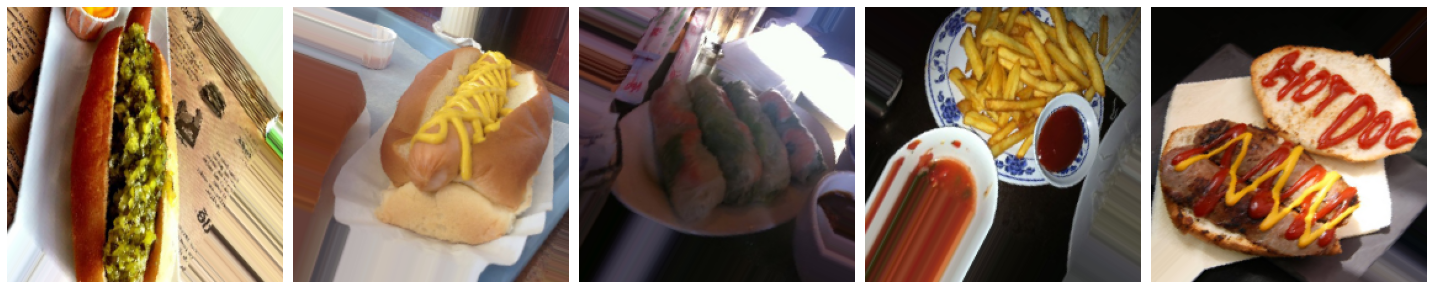

In [17]:
plotImages(sample_training_images[:5])

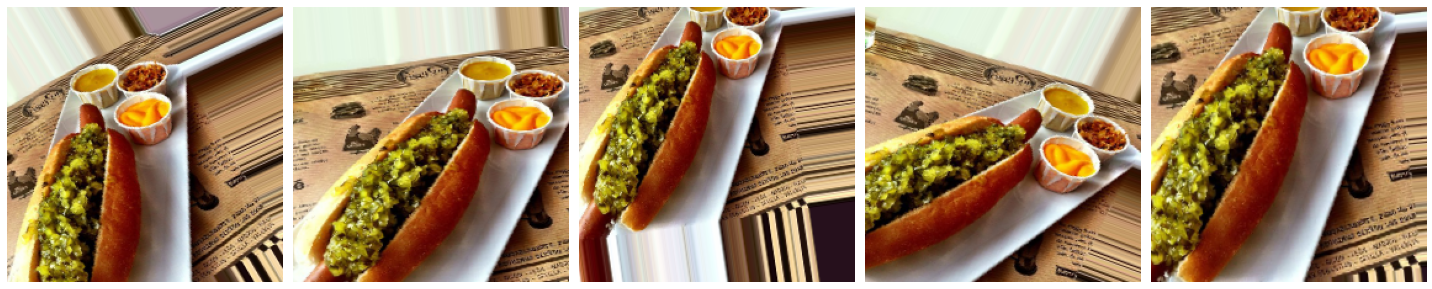

In [18]:
# visualize augmented images

augmented_images = [train_data_gen[0][0][0] for i in range(5)]
plotImages(augmented_images)

## Create the model from the pre-trained convnets

In [23]:
module = ("mobilenet_v2_100_224", 224)
handle_base, pixels = module

MODULE_HANDLE = "https://tfhub.dev/google/imagenet/{}/feature_vector/4".format(handle_base)
IMAGE_SIZE = (pixels, pixels)
print("Using {} with input size {}".format(MODULE_HANDLE, IMAGE_SIZE))

BATCH_SIZE = 32

Using https://tfhub.dev/google/imagenet/mobilenet_v2_100_224/feature_vector/4 with input size (224, 224)


In [30]:
do_fine_tuning = False

In [41]:
print("Building model with ", MODULE_HANDLE)

model = Sequential([
    InputLayer(input_shape=IMAGE_SIZE + (3,)),
    hub.KerasLayer(MODULE_HANDLE, trainable=do_fine_tuning),
    Dropout(rate=0.2),
    Dense(train_data_gen.num_classes,
          kernel_regularizer=tf.keras.regularizers.l2(0.0001))
])

model.build((None,) + IMAGE_SIZE+(3,))

Building model with  https://tfhub.dev/google/imagenet/mobilenet_v2_100_224/feature_vector/4


## Compile the model

In [37]:
model.compile(
    optimizer=SGD(lr=0.005, momentum=0.9),
    loss=CategoricalCrossentropy(from_logits=True, label_smoothing=0.1),
    metrics=['accuracy']
)

## Model summary

In [42]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
keras_layer_2 (KerasLayer)   (None, 1280)              2257984   
_________________________________________________________________
dropout_2 (Dropout)          (None, 1280)              0         
_________________________________________________________________
dense_2 (Dense)              (None, 2)                 2562      
Total params: 2,260,546
Trainable params: 2,562
Non-trainable params: 2,257,984
_________________________________________________________________


## Training

In [40]:
steps_per_epoch = train_data_gen.samples // train_data_gen.batch_size
validation_steps = val_data_gen.samples // val_data_gen.batch_size


history = model.fit(train_data_gen, 
                    epochs=15, steps_per_epoch=steps_per_epoch,
                    validation_data = val_data_gen,
                    validation_steps=validation_steps)

Epoch 1/15
19/19 [==============================] - 13s 703ms/step - loss: 0.5572 - accuracy: 0.7573 - val_loss: 0.4230 - val_accuracy: 0.8750
Epoch 2/15
19/19 [==============================] - 13s 680ms/step - loss: 0.4634 - accuracy: 0.8899 - val_loss: 0.3692 - val_accuracy: 0.9100
Epoch 3/15
19/19 [==============================] - 13s 690ms/step - loss: 0.4042 - accuracy: 0.8846 - val_loss: 0.4136 - val_accuracy: 0.8600
Epoch 4/15
19/19 [==============================] - 13s 689ms/step - loss: 0.3900 - accuracy: 0.9072 - val_loss: 0.3728 - val_accuracy: 0.9000
Epoch 5/15
19/19 [==============================] - 13s 687ms/step - loss: 0.3895 - accuracy: 0.8886 - val_loss: 0.3787 - val_accuracy: 0.9050
Epoch 6/15
19/19 [==============================] - 13s 682ms/step - loss: 0.3757 - accuracy: 0.8979 - val_loss: 0.3546 - val_accuracy: 0.9150
Epoch 7/15
19/19 [==============================] - 13s 683ms/step - loss: 0.3600 - accuracy: 0.9032 - val_loss: 0.3481 - val_accuracy: 0.9150

## Visualize training results



<Figure size 432x288 with 0 Axes>

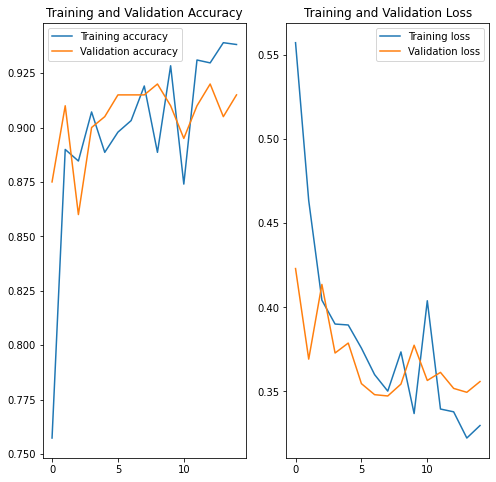

In [49]:
plt.figure()

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label="Training accuracy")
plt.plot(epochs_range, val_acc, label="Validation accuracy")
plt.legend()
plt.title("Training and Validation Accuracy")

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label="Training loss")
plt.plot(epochs_range, val_loss, label="Validation loss")
plt.legend()
plt.title("Training and Validation Loss")
plt.show()

## Make Predictions

In [57]:
class_names = sorted(train_data_gen.class_indices.items(), key=lambda pair:pair[1])
class_names = np.array([key.title() for key, value in class_names])
class_names

array(['Hot_Dog', 'Not_Hot_Dog'], dtype='<U11')

16384/15772 [===============================] - 0s 0us/step


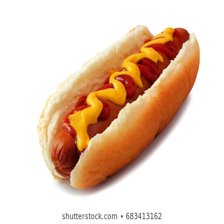

In [69]:
import PIL.Image as Image

# https://image.shutterstock.com/image-photo/slice-fresh-italian-classic-original-260nw-338558108.jpg
# https://image.shutterstock.com/image-photo/hot-dog-mustard-ketchup-side-260nw-683413162.jpg
img = tf.keras.utils.get_file("image1.jpg", "https://image.shutterstock.com/image-photo/hot-dog-mustard-ketchup-side-260nw-683413162.jpg" )
img = Image.open(img).resize(IMAGE_SIZE)
img

In [70]:
img = np.array(img)/255
img.shape

(224, 224, 3)

In [71]:
result = model.predict(img[np.newaxis, ...])
print(result.shape)
print(result)

(1, 2)
[[ 0.844997  -0.0646302]]


In [72]:
predicted_class = np.argmax(result[0], axis=-1)
print(class_names[predicted_class])

Hot_Dog


## Export your model

In [ ]:
from google.colab import drive
drive.mount('/gdrive')

In [55]:
tf.saved_model.save(model, "/gdrive/My Drive/models/seefood")

INFO:tensorflow:Assets written to: /gdrive/My Drive/models/seefood/assets


INFO:tensorflow:Assets written to: /gdrive/My Drive/models/seefood/assets
